In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import qutip as qt

In [2]:
segment_count = 10
segment_width = 2.0
duration = segment_count * segment_width

values_i = np.random.uniform(0, 1, size=segment_count)
values_q = np.random.uniform(0, 1, size=segment_count)
values = values_i + 1j * values_q
norm_factor = np.sum(np.abs(values)) * segment_width
values = 3 * np.pi * values / norm_factor
durations = [segment_width] * segment_count

pwc = {"values": values, "durations": durations}

In [3]:
np.sum(np.abs(values)) * segment_width

9.42477796076938

In [4]:
pwc

{'values': array([0.21484242+0.12398851j, 0.5130033 +0.03102731j,
        0.34845948+0.51279861j, 0.1347539 +0.48688529j,
        0.59368166+0.00886438j, 0.56926053+0.3781726j ,
        0.01962891+0.3107672j , 0.59338932+0.36231128j,
        0.0692565 +0.2929397j , 0.22156913+0.0932317j ]),
 'durations': [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]}

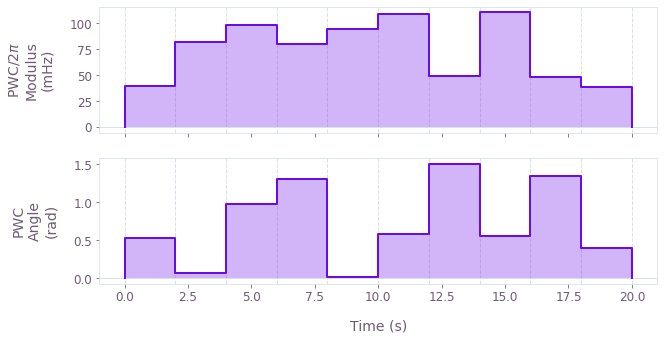

In [5]:
qv.plot_controls({"PWC": pwc})

In [6]:
dimension = 3
detuning = 0.0
anharmonicity = -0.3
omega = 2 * np.pi * detuning
alpha = 2 * np.pi * anharmonicity

a = qt.destroy(dimension)
ad = a.dag()

H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a


def propagator(value: complex, duration: float):
    H_ctrl = 0.5 * ad * value + 0.5 * a * np.conj(value)
    H = H_sys + H_ctrl
    # U = qt.propagator(H, duration)
    U = (-1j * H * duration).expm()
    return U


times = [0]
for duration in pwc["durations"]:
    times.append(times[-1] + duration)


unitaries = [qt.qeye(dimension)]
for value, duration in zip(pwc["values"], pwc["durations"]):
    U = propagator(value, duration) * unitaries[-1]
    unitaries.append(U)

target_unitary = qt.qeye(dimension)

initial_state = qt.basis(dimension, 0)
states = [U * initial_state for U in unitaries]

In [7]:
def unitary_infidelity(U1: qt.Qobj, U2: qt.Qobj):
    return 1 - np.abs((U1.dag() * U2).tr() / dimension) ** 2


infidelities = [unitary_infidelity(U, target_unitary) for U in unitaries]

In [8]:
def display_bloch_sphere(states):
    states = np.array(states).squeeze()
    qv.display_bloch_sphere(states[:, :2])


def plot_populations(times, states):
    times = np.array(times, dtype=float)
    states = np.array(states).squeeze()
    populations = np.abs(states) ** 2
    qv.plot_population_dynamics(
        sample_times=times,
        populations={rf"$|{k}\rangle$": populations[:, k] for k in range(dimension)},
    )


def print_final_populations(states):
    states = np.array(states).squeeze()
    populations = np.abs(states[-1]) ** 2
    for k in range(dimension):
        print(f"|{k}> : {populations[k]:>6.2%}")


def plot_unitary_infidelities(times, infidelities):
    plt.plot(times, infidelities, "x", color="black", label="Infidelity")
    plt.plot(times, infidelities, "--", color="black", alpha=0.5, linewidth=1)
    plt.grid(color="gray", linestyle="--", alpha=0.2)
    plt.ylim(0, 1)

In [9]:
unitary_infidelity(unitaries[-1], qt.identity(dimension))

0.5201390207847119

In [10]:
print_final_populations(states)

|0> : 56.18%
|1> : 41.34%
|2> :  2.49%


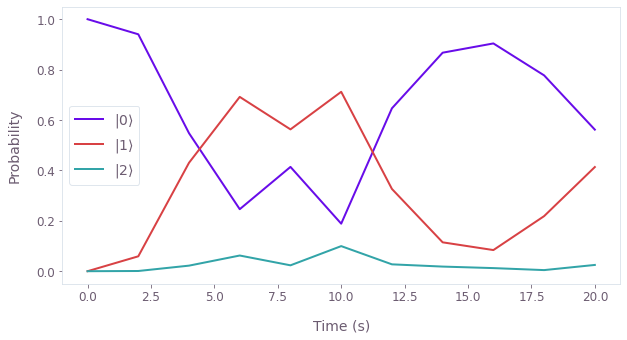

In [11]:
plot_populations(times, states)

In [12]:
display_bloch_sphere(states)

<IPython.core.display.Javascript object>

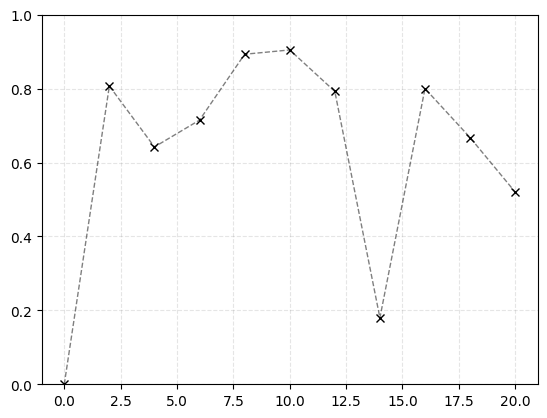

In [13]:
plot_unitary_infidelities(times, infidelities)

In [14]:
infidelities

[0.0,
 0.8069702389773408,
 0.6421252529669421,
 0.7147710240562997,
 0.8929290238545751,
 0.9045906718620436,
 0.7924862162803166,
 0.17983469935979635,
 0.8000387621204358,
 0.6674690559102212,
 0.5201390207847119]